In [1]:
import pandas as pd
import string
import emoji
import optuna

In [2]:
def replace_polish_lowercase(text):
    polish_to_latin = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n', 
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z'
    }
    return ''.join(polish_to_latin.get(char, char) for char in text)

def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Replace emojis
    text = replace_emojis(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove polish letters
    text = replace_polish_lowercase(text)
    # Tokenize (split by whitespace)
    tokens = text.split()
    return ' '.join(tokens)  # Join tokens back into a string for TF-IDF

In [3]:
FILENAME_DEV = './data/dataset_conll/all.sentence.dev.txt'
FILENAME_TRAIN = './data/dataset_conll/all.sentence.train.txt'
FILENAME_TEST = './data/dataset_conll/all.sentence.test.txt'

LABELS = {
    "__label__z_minus_m": "Negative sentiment", 
    "__label__z_plus_m": "Positive sentiment",
    "__label__z_zero": "No sentiment",
    "__label__z_amb": "Unsure",
    }


In [4]:
def load_df(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        data = [line.strip() for line in lines]
        # get last word from each item as a label and match with data
        labeled_data = []
        for item in data:
            label = item.split()[-1]
            sentence_data = ' '.join(item.split()[:-1])
            labeled_data.append((sentence_data, LABELS[label]))

        # create a dataframe
        df = pd.DataFrame(labeled_data, columns=['text', 'labels'])
        return df

# Read data

In [5]:
df_train = load_df(FILENAME_TRAIN)
df_test = load_df(FILENAME_TEST)

In [6]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [7]:
df_train.sample(5)

,text,labels
19270,widac ze caly zespol dobrze ze soba wspolpracuje,Positive sentiment
345,jedynym pozytywem w leo to baza zabiegowa poza...,Unsure
43278,decydujac sie na operacje ponosimy ryzyko na k...,No sentiment
40884,na drugi dzien nie mogli smy zostac do rozpocz...,Negative sentiment
33171,jedzenie jak to w hotelu z oferta all inclusive,Unsure


# BERT fine tuning

In [8]:
import torch  # transformers couldn't find torch without manual import
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from torch.utils.data import Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained("dkleczek/bert-base-polish-uncased-v1")
model = AutoModelForSequenceClassification.from_pretrained(
    "dkleczek/bert-base-polish-uncased-v1",
    num_labels=4
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
def prepare_data_for_training(df):
    label_map = {
        'Negative sentiment': 0,
        'Positive sentiment': 1,
        'No sentiment': 2,
        'Unsure': 3,
    }
    
    labels = [label_map[label] for label in df['labels']]
    texts = df['text'].tolist()
    
    return texts, labels

In [21]:
def train_classifier(train_df, test_df, model):
    train_texts, train_labels = prepare_data_for_training(train_df)
    test_texts, test_labels = prepare_data_for_training(test_df)
    
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    def objective(trial):
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

        training_args = TrainingArguments(
            output_dir="./output/results_optuna",
            num_train_epochs=1,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            learning_rate=learning_rate,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            logging_dir="./logs_optuna",
            report_to=["none"],
            no_cuda=False,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        trainer.train()

        eval_results = trainer.evaluate()
        return eval_results["eval_loss"]

    print("Hyperparameter optimalization...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=2)

    best_params = study.best_params
    print("Best parameters: ", best_params)

    training_args = TrainingArguments(
        output_dir="./output/results",
        num_train_epochs=1,
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        warmup_steps=500,
        weight_decay=0.01,
        learning_rate=best_params["learning_rate"],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_dir="./logs",
        logging_steps=10,
        report_to=["none"],
        no_cuda=False,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()

    return trainer, model, best_params

In [19]:
def predict(texts, model):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to('cuda')
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    label_map_reverse = {
        0: 'Negative sentiment',
        1: 'Positive sentiment',
        2: 'No sentiment',
        3: 'Unsure',
    }
    
    pred_labels = [label_map_reverse[pred.argmax()] for pred in predictions.detach().numpy()]
    return pred_labels, predictions.detach().cpu().numpy()

In [22]:
trainer, model, best_params = train_classifier(df_train, df_test, model)

[I 2025-01-15 04:41:09,202] A new study created in memory with name: no-name-33a13c78-cafc-4668-b0cc-73b1fbccaca7


Hyperparameter optimalization...


Epoch,Training Loss,Validation Loss
1,0.271500,0.738543


[I 2025-01-15 04:46:51,397] Trial 0 finished with value: 0.7385428547859192 and parameters: {'learning_rate': 4.8927289446355624e-05, 'batch_size': 16}. Best is trial 0 with value: 0.7385428547859192.


Epoch,Training Loss,Validation Loss
1,0.569300,1.166662


[I 2025-01-15 04:55:08,074] Trial 1 finished with value: 1.1666624546051025 and parameters: {'learning_rate': 1.4955094075133815e-05, 'batch_size': 8}. Best is trial 0 with value: 0.7385428547859192.


Best parameters:  {'learning_rate': 4.8927289446355624e-05, 'batch_size': 16}


Epoch,Training Loss,Validation Loss
1,0.876800,0.853634


In [23]:
model.save_pretrained("./output/kaggle/pretrained/results")

BERT Accuracy: 0.77
BERT Precision: 0.76
BERT Recall: 0.77
BERT F1: 0.76


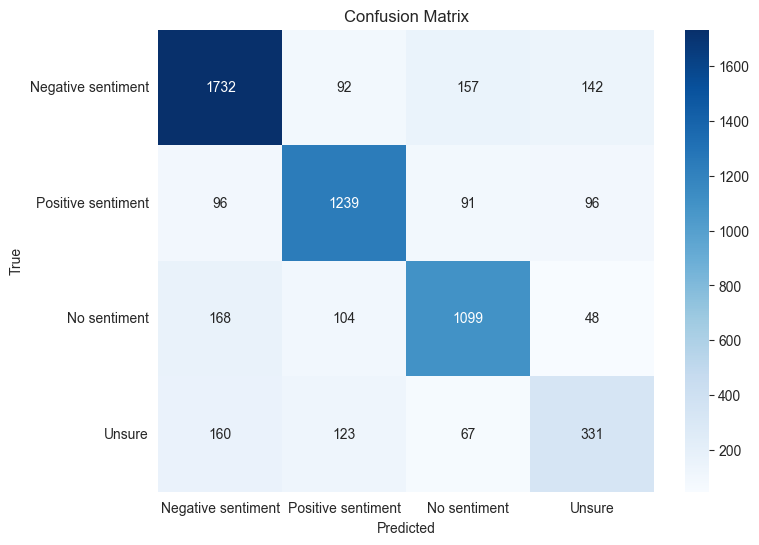

In [24]:
test_texts, test_labels = prepare_data_for_training(df_test)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

from torch.utils.data import DataLoader
import torch
from util import model_summary, save_model_summary_dict, show_model_summary_dict

test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != "labels"}
        labels = batch['labels'].to(model.device)

        # Forward pass
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


summary = model_summary(all_labels, all_preds, list(LABELS.values()), "BERT", is_y_indices=True)
save_model_summary_dict(summary)
show_model_summary_dict(summary)
